# **Movie Recommendation System**

---

In [55]:
# Importing the necessary libraries
!pip install numpy pandas matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [56]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

In [57]:
!pip install fuzzywuzzy
!pip install scikit-surprise

In [58]:


from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [59]:
from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

## **3. Data Preparation/Preprocessing**


In [60]:
# Loading the dataset

file_path = "ml-20m"

movie_ratings = pd.read_csv(file_path + "/ratings.csv")
movies = pd.read_csv(file_path + "/movies.csv")

In [61]:
# Creating a newId for every movie to reduce the range of existing movieId

movies["newId"] = range(1, movies["movieId"].nunique()+1)

In [62]:
# Converting the the UTC timestamp to Datetime
movie_ratings["timestamp"] = movie_ratings["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x).strftime("%Y-%m-%d"))

# Merging the movies and ratings data files
movie_ratings = movie_ratings.merge(movies, how="left", on="movieId")

# Renaming the timestamp to date
movie_ratings.rename(columns={"timestamp": "date"}, inplace=True)

# Updating the movieId with the newId
movie_ratings["movieId"] = movie_ratings["newId"]
movies["movieId"] = movies["newId"]

In [63]:
# Dropping the newId from the datasets
movie_ratings.drop(["newId"], axis=1, inplace=True)
movies.drop(["newId"], axis=1, inplace=True)

# Sorting ratings based on date
movie_ratings.sort_values(by = "date", inplace = True)
movie_ratings.reset_index(drop=True, inplace=True)

In [64]:
# Checking the features and no. of records in the dataset

print("The number of records are : ", movie_ratings.shape[0])
print("The number of features are : ", movie_ratings.shape[1])
print("The list of features is : ", movie_ratings.columns)
movie_ratings.head()

The number of records are :  20000263
The number of features are :  6
The list of features is :  Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


### **3.1 Data Cleaning**



In [89]:
# Checking for duplicates

print("No. of duplicates records in the dataset : ", movie_ratings.columns.duplicated().sum())

No. of duplicates records in the dataset :  0


In [66]:
# Checking the columns' titles and datatypes

movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   date     object 
 4   title    object 
 5   genres   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


#### **3.1.1 Handling Missing Values**


In [67]:
# Checking the number of missing values in data

movie_ratings.isna().sum()

userId     0
movieId    0
rating     0
date       0
title      0
genres     0
dtype: int64

#### **3.2.1 Univariate Analysis**

In [68]:
# Checking the feature "userID"

total_users = len(np.unique(movie_ratings["userId"]))
print("The count of unique userID in the dataset is : ", total_users)
print("The top 5 userID in the dataset are : \n", movie_ratings["userId"].value_counts()[:5])

The count of unique userID in the dataset is :  138493
The top 5 userID in the dataset are : 
 userId
118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
Name: count, dtype: int64


In [69]:
# Checking the feature "movieID"

total_movies = len(np.unique(movie_ratings["movieId"]))
print("The count of unique movieID in the dataset is : ", total_movies)
print("The top 5 movieID in the dataset are : \n", movie_ratings["movieId"].value_counts()[:5])

The count of unique movieID in the dataset is :  26744
The top 5 movieID in the dataset are : 
 movieId
294    67310
353    66172
316    63366
588    63299
477    59715
Name: count, dtype: int64


In [90]:
# Helper function to Change the numeric label in terms of Millions

def changingLabels(number):

    return str(number/10**6) + "M"

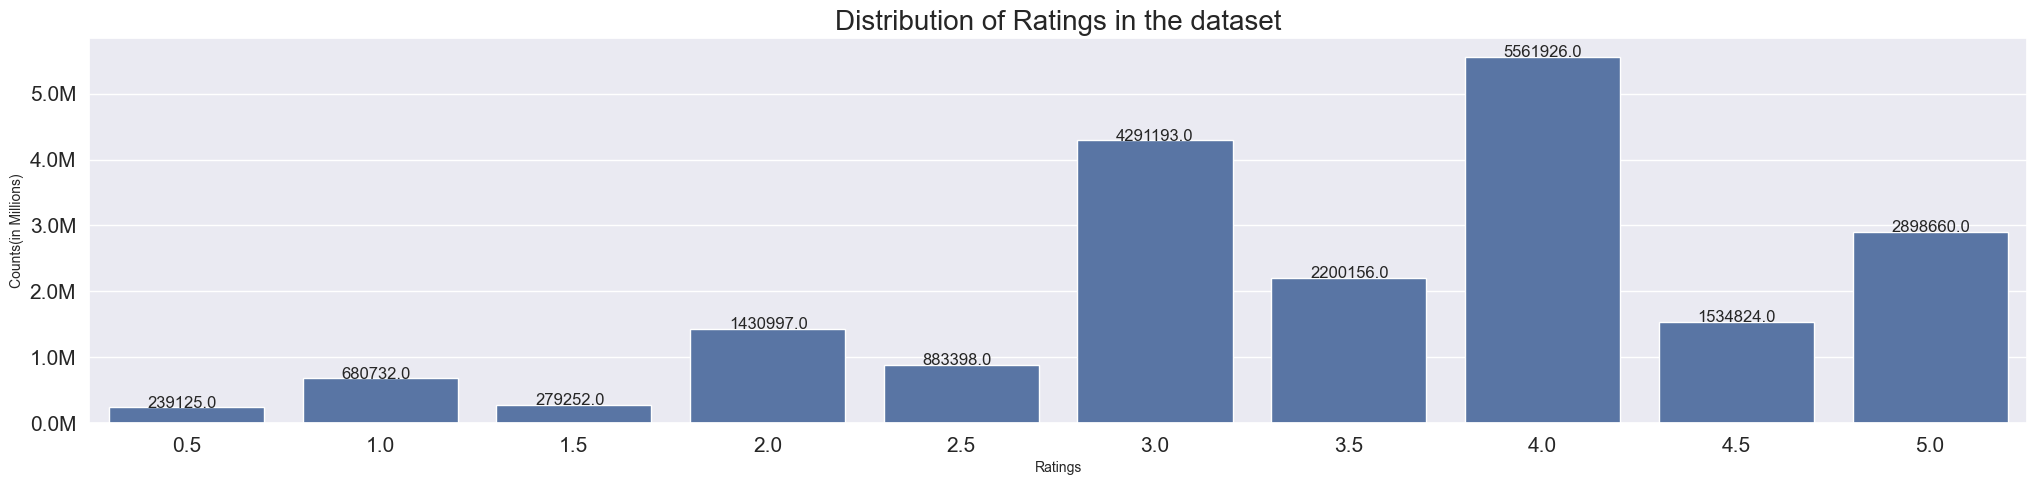

In [71]:
# Checking the feature "rating"

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

# sns.countplot("rating", data=movie_ratings, ax=axes)
sns.countplot(x="rating", data=movie_ratings, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

In [72]:
# Checking the feature "date"

print("The count of unique date in the dataset is : ", movie_ratings["date"].nunique())
print("The first rating was given on : ", movie_ratings["date"].min())
print("The latest rating was given on : ", movie_ratings["date"].max())
print("The top 5 date in the dataset are : \n", movie_ratings["date"].value_counts()[:5])

The count of unique date in the dataset is :  6911
The first rating was given on :  1995-01-09
The latest rating was given on :  2015-03-31
The top 5 date in the dataset are : 
 date
2000-11-20    91753
2005-03-22    76568
1999-12-11    65077
2008-10-29    55163
2000-11-21    54131
Name: count, dtype: int64


In [73]:
# Checking the feature "title"

movie_list = movie_ratings["title"].unique()
print("The count of unique title in the dataset is : ", movie_ratings["title"].nunique())
print("The top 5 title in the dataset are : \n", movie_ratings["title"].value_counts()[:5])

The count of unique title in the dataset is :  26729
The top 5 title in the dataset are : 
 title
Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: count, dtype: int64


In [74]:
# Extract unique Genres along with their count

unique_genres = {}

def ExtractGenres(x):
    for g in x.split("|"):
        if g not in unique_genres.keys():
            unique_genres[g] = 1
        else:
            unique_genres[g] = unique_genres[g] + 1

movie_ratings["genres"].apply(ExtractGenres)
print("Genres Extracted from the dataset.")

Genres Extracted from the dataset.


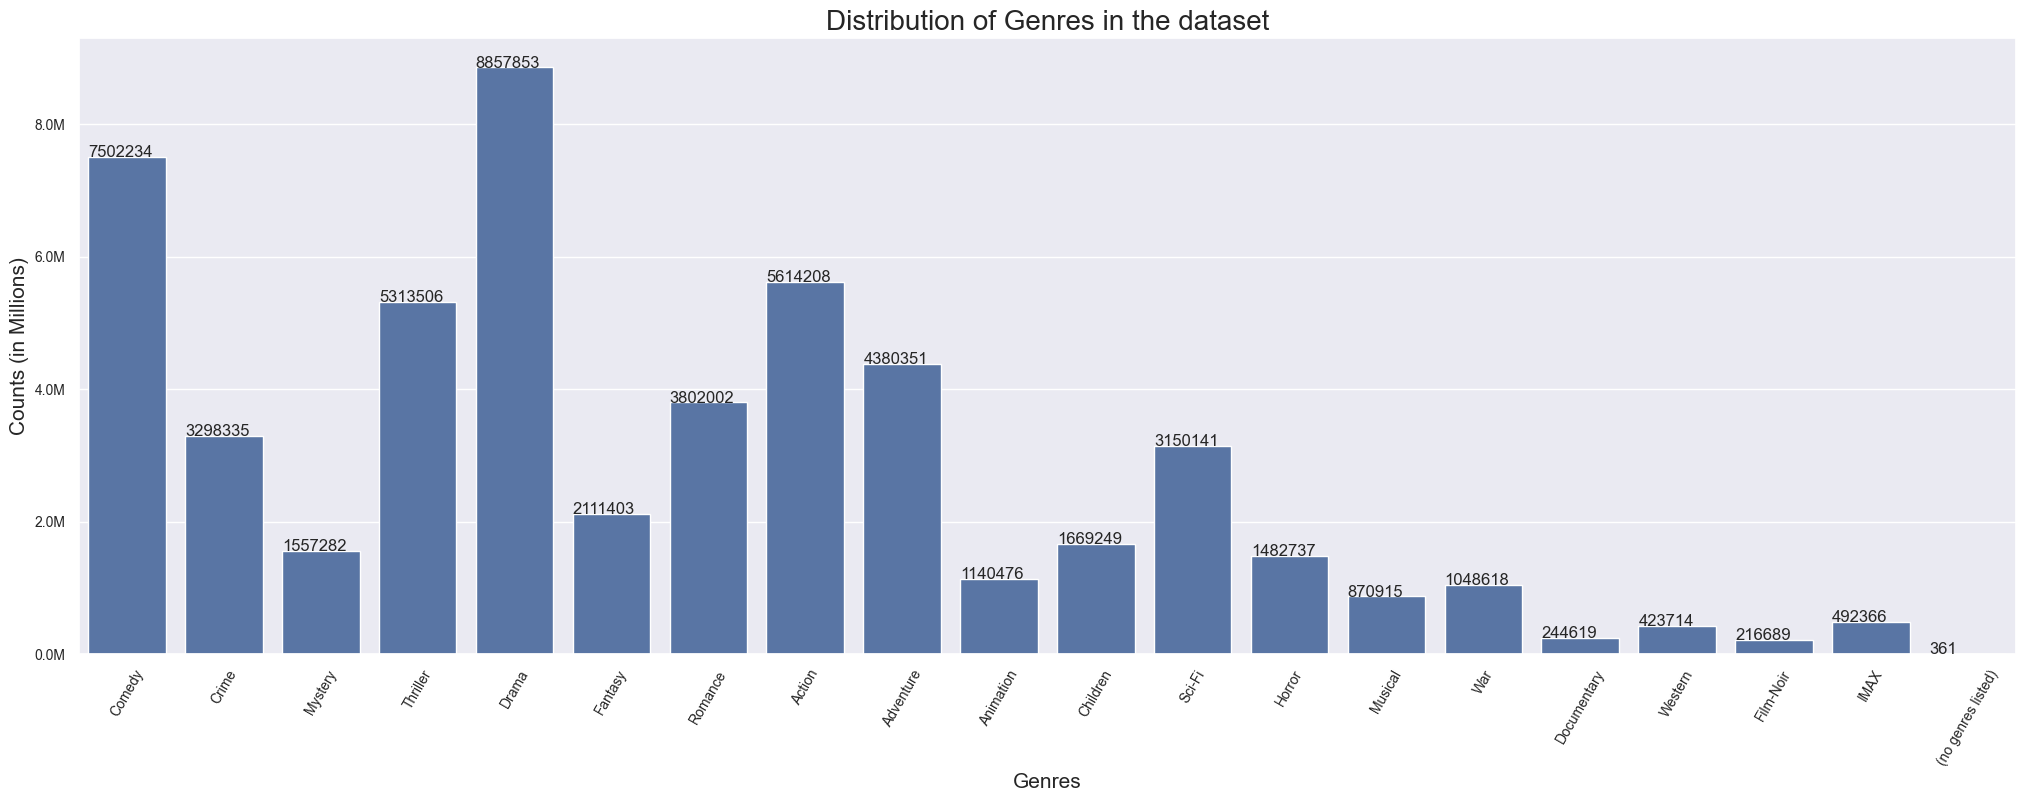

In [75]:
# Visualizing the feature "Genres"

genres_df = pd.DataFrame(list(unique_genres.items()))
genres_df.columns = ["Genre", "Count"] 

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 8), sharey=True)

sns.barplot(y="Count", x="Genre", data=genres_df, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Genres in the dataset", fontsize = 20)
plt.xlabel("Genres", fontsize = 15)
plt.xticks(rotation=60, fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

In [76]:
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


#### **3.2.2 Train & test Splitting**


In [77]:
# Creating the train test set

file_path = "ml-20m"

if not os.path.isfile(file_path + "/TrainData.pkl"):
    print("Creating Train Data and saving it..")
    movie_ratings.iloc[:int(movie_ratings.shape[0] * 0.80)].to_pickle(file_path + "/TrainData.pkl")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    print("Loading Train Data..")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile(file_path + "/TestData.pkl"):
    print("Creating Test Data and saving it..")
    movie_ratings.iloc[int(movie_ratings.shape[0] * 0.80):].to_pickle(file_path + "/TestData.pkl")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    print("Loading Test Data..")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

Loading Train Data..
Loading Test Data..


In [78]:
Train_Data.head()

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


In [79]:
# Creating list of unique movies from Train Set

movie_list_in_training = Train_Data.drop_duplicates(subset=["title"], keep="first")[["movieId", "title", "genres"]]
movie_list_in_training = movie_list_in_training.reset_index(drop=True)
movie_list_in_training.head()

,movieId,title,genres
0,1058,"Fish Called Wanda, A (1988)",Comedy|Crime
1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,1154,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,21,Get Shorty (1995),Comedy|Crime|Thriller
4,7,Sabrina (1995),Comedy|Romance


In [80]:
# Checking the basic statistics for the training data

print("Total Train Data..")
print("Total number of movie ratings in train data : ", str(Train_Data.shape[0]))
print("Number of unique users in train data : ", str(len(np.unique(Train_Data["userId"]))))
print("Number of unique movies in train data : ", str(len(np.unique(Train_Data["movieId"]))))

Total Train Data..
Total number of movie ratings in train data :  16000210
Number of unique users in train data :  112466
Number of unique movies in train data :  12387


#### **3.2.3 Bi-variate Analysis**


In [81]:
# Checking basic statistics for "rating"

print("The basic statistics for the feature is : \n", Train_Data["rating"].describe())

The basic statistics for the feature is : 
 count    1.600021e+07
mean     3.512613e+00
std      1.059931e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


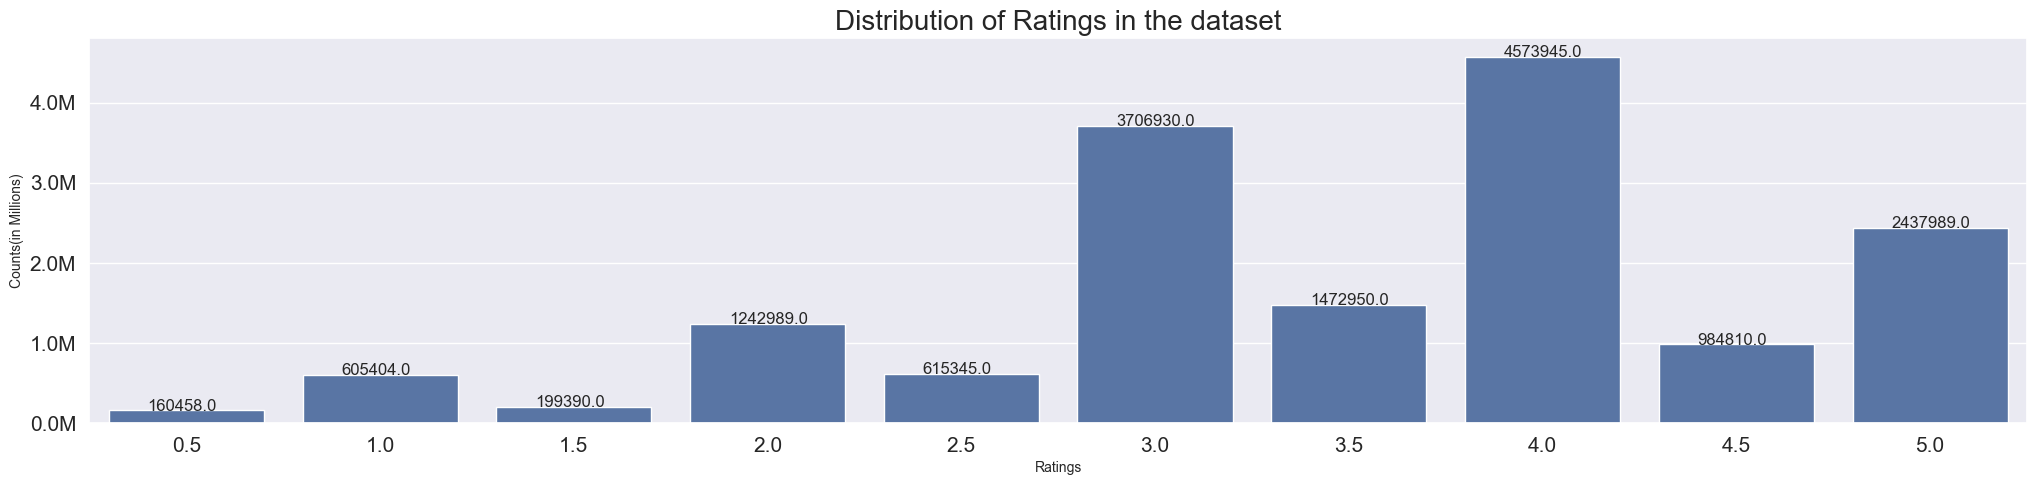

In [82]:
# Visualizing the "rating" for the train set

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.countplot(x="rating", data=Train_Data, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

In [83]:
# Extracting the day of week from the date when rating was provided

Train_Data["date"] = pd.to_datetime(Train_Data["date"], errors='coerce')
Train_Data["DayOfWeek"] = Train_Data["date"].dt.strftime('%A')
Train_Data["Weekday"] = Train_Data["date"].apply(lambda x : 1 if x.dayofweek > 5 else 0)

In [84]:
# Converting the number into 'Ks.

def ChangingLabelsInK(number):
    return str(int(number/10**3)) + "K"

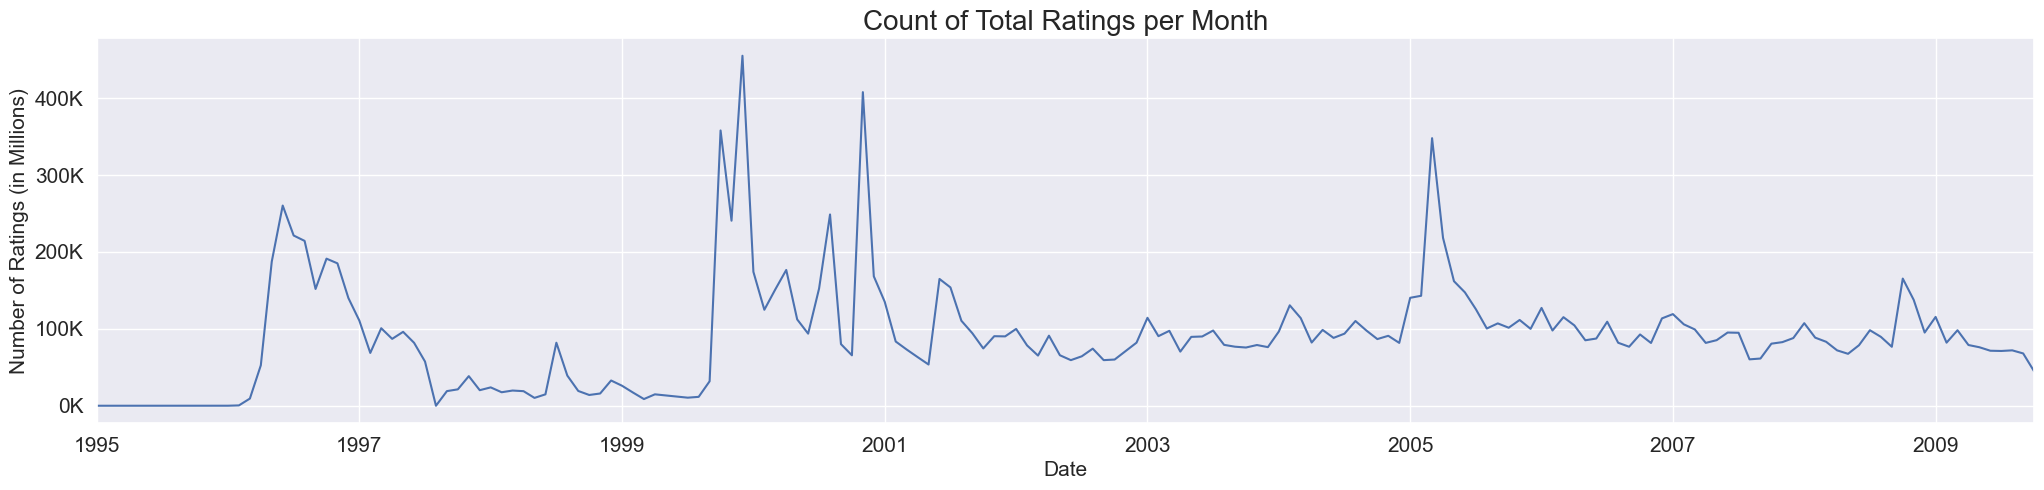

In [85]:
# Visualizing the count of total ratings made per month

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
axes = Train_Data.resample("m", on = "date")["rating"].count().plot()

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
axes.set_title("Count of Total Ratings per Month", fontsize = 20)
axes.set_xlabel("Date", fontsize = 15)
axes.set_ylabel("Number of Ratings (in Millions)", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.show()

---

**2.1. Computing Item-Item Similarity Matrix**

In [86]:
# Computing user-user similarity matrix for the train data
# We have 138K sized sparse vectors using which a 14K x 14K movie similarity matrix would be calculated

start = datetime.now()

if not os.path.isfile(file_path + "/m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Dimension of Matrix : ", m_m_similarity.shape)
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz(file_path + "/m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz(file_path + "/m_m_similarity.npz")
    print("Dimension of Matrix : ", m_m_similarity.shape)
    
print("The time taken to compute movie-movie similarity matrix is : ", datetime.now() - start)

File exists in the disk. Loading the file...
Dimension of Matrix :  (14334, 14334)
The time taken to compute movie-movie similarity matrix is :  0:00:07.423423


In [87]:
# Creating a function to take Movie Name and generate the top matched name and generate its N similar movies based on M-M Similary

def GetSimilarMoviesUsingMovieMovieSimilarity(movie_name, num_of_similar_movies):
    matches = process.extract(movie_name, movie_list_in_training["title"], scorer=fuzz.partial_ratio)
    if len(matches) == 0:
        return "No Match Found"
    movie_id = movie_list_in_training.iloc[matches[0][2]]["movieId"]
    similar_movie_id_list = np.argsort(-m_m_similarity[movie_id].toarray().ravel())[0:num_of_similar_movies+1]
    sm_df = movie_list_in_training[movie_list_in_training["movieId"].isin(similar_movie_id_list)]
    sm_df["order"] = sm_df.apply(lambda x: list(similar_movie_id_list).index(x["movieId"]), axis=1)
    
    return sm_df.sort_values("order")

In [88]:
# Picking random movie and checking it's top 10 most similar movies

GetSimilarMoviesUsingMovieMovieSimilarity("Star Trek", 10)

,movieId,title,genres,order
266,326,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi,0
275,314,Stargate (1994),Action|Adventure|Sci-Fi,1
302,152,Batman Forever (1995),Action|Adventure|Comedy|Crime,2
187,587,Batman (1989),Action|Crime|Thriller,3
148,377,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller,4
217,346,Clear and Present Danger (1994),Action|Crime|Drama|Thriller,5
303,149,Apollo 13 (1995),Adventure|Drama|IMAX,6
323,290,Outbreak (1995),Action|Drama|Sci-Fi|Thriller,7
317,164,Die Hard: With a Vengeance (1995),Action|Crime|Thriller,8
134,477,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,9
